<a href="https://colab.research.google.com/github/Nick7900/permutation_test/blob/main/a_between_subject_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)
This tutorial demonstrates how apply ```across-subject``` testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm). 
We will use data sourced from the Human Connectome Project (HCP) S1200 Young Adult dataset ([van Essen et al., 2013]((https://pubmed.ncbi.nlm.nih.gov/23684880/))).\
Make sure you have been granted permission to use the HCP data. If not, apply for such permission following the instructions in the [HCP Data](https://db.humanconnectome.org/) website. The HCP dataset provides an real-world context for this analysis and offers detailed information for each subject. ```Across-subject``` testing involves evaluating the connection between one or more HMM-related aggregated statistics and behavioral traits, such as sex and age or individual traits.

We'll set up HMM-related aggregated statistics as the independent variable (```X_data```) and behavioral traits as the dependent variable (```Y_data```). The objective is to assess the relationship between these variables.

Throughout the tutorial, we'll guide you on applying the [glhmm toolbox](https://github.com/vidaurre/glhmm) and drawing conclusions from the HCP dataset. While the setup of the ```glhmm toolbox``` may require some explanation, running the test itself is straightforward—simply input the ```X_data``` and ```Y_data```, and define the specific ```method``` you wish to apply. In this case, the methods include permutation using regression or permutation using correlation.

## Table of Contents
1. [Load and prepare data](#load-data)
    * [HMM-aggregated statistics](#HMM-agg)
2. [Across-Subjects testing](#across_subjects)
    * [Family structure](#fam-struc)
    * [Across subjects - Regression](#perm-regression)
    * [Across subjects - Correlation](#perm-correlation)


### Install necessary packages
To run this this script we need to install the required packages:

### Import libraries
Let's start by importing the required libraries and modules.

In [3]:
import os
import numpy as np
import pandas as pd
import glhmm.glhmm as glhmm
from helperfunctions import get_timestamp_indices

## 1. Load and prepare Data <a id="load-data"></a>
For reproducibility and since the HCP dataset is very large, we provide the ```Gamma``` values (state probabilities at each timepoint) from a pre-trained HMM. If you don't have these values, you can follow the instructions to train an HMM model in this [tutorial](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/tutorial.ipynb) from the [glhmm toolbox](https://github.com/vidaurre/glhmm).

**Load Data**
Let's start by loading the essential data for this tutorial:
* ```Gamma```: State probabilities at each timepoint exported from a fitted HMM model. The model is trained on HCP rest fMRI timeseries from 1001 subjects in the groupICA50 parcellation.
* ```data_behavioral```: Behavioral and demographic items from the same 1001 HCP subjects.



In [4]:
# Define the folder and file names
folder_name = "data"
data_behavioral_file = 'data_behavioral_whole.npy'
data_gamma_file = 'gamma_whole.npy'

# Load behavioral data
file_path = os.path.join(folder_name, data_behavioral_file)
data_behavioral = np.load(file_path)

# Load gamma data
file_path = os.path.join(folder_name, data_gamma_file)
data_gamma = np.load(file_path)

**Explore data**\
Let's take a closer look at the structure of the data.

In [5]:
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")
print(f"Data dimension of data_gamma: {data_gamma.shape}")

Data dimension of data_behavioral: (1001, 2)
Data dimension of data_gamma: (1201200, 8)


The behavioral measurements, denoted as ```data_behavioral``` =[1001, 2], reveals that we have measurements for 1001 subjects. Each subject include information about their 'sex' and 'age'.

Looking at ```data_gamma``` =[1201200, 8], we find that gamma measurements are concatenated for every timepoint across subjects (1201200 in total, corresponding to 1001 subjects by 1200 timestamps). The dataset comprises 8 columns, each representing the 8 different states at each timepoint per subject. 


### HMM-aggregated statistics <a id="HMM-agg"></a>

The purpose of the ```across_subject``` function is to conduct permutation tests between subjects. Like mentioned earlier, the ```data_gamma``` is a concatenated dataset across subjects and timepoints, totaling 1201200 data points (1001 subjects by 1200 time points) with 8 columns representing different states at each timepoint per subject.\
To perform permutation testing using the ```across_subject``` function, we first need to compute HMM-related aggregated statistics. This involves deriving values that condense the states of the entire time series for each subject, resulting in a single set of values per subject (one row of data).
Since we have gamma output from the HMM, we can calculate the Fractional Occupancy (FO). FO measures the duration spent in each state, providing the probability distribution for each state across the entire time series. As a result, each subject ends up with a single set of values that represents the states into a probability distribution that sums up to one for each subject.

**Calculate indices**\
To calculate the FO from the gamma values, we must first specify the indices in the concatenated timeseries that correspond to the beginning and end of individual subjects or sessions. These indices should be organized in the shape of [n_subjects, 2] to precisely delineate subject boundaries within the concatenated timeseries.



To achieve this, we'll use the function ```get_timestamp_indices```. By providing the number of time points (1200) and the number of subjects (1001), the function outputs a variable in the shape of (n_subjects, 2). This variable contains the indices for the beginning and end of each subject's scanning session.




In [6]:
# Prepare the number of time points and number of subjects
n_timepoints = 1200
n_subjects = 1001
idx_time = get_timestamp_indices(n_timepoints, n_subjects)

Let's visualize the the first 5 time points

In [7]:
# Visualize the first 5 timepoints
idx_time[:5]

array([[   0, 1200],
       [1200, 2400],
       [2400, 3600],
       [3600, 4800],
       [4800, 6000]])

**Calculate Fractional Occupancy (FO)**
Having obtained the necessary indices (```idx_time```), we can now proceed to calculate the FO using the [glhmm toolbox](https://github.com/vidaurre/glhmm).

In [8]:
# Calculate FO
FO = glhmm.utils.get_FO(data_gamma, idx_time)

Let's take a closer look at the structure of FO and the behavioral data.

In [9]:
print(f"Data dimension of FO: {FO.shape}")
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")

Data dimension of FO: (1001, 8)
Data dimension of data_behavioral: (1001, 2)


In this example, (```FO```) is a 1001x8 matrix and represent the distribution of the duration spent in different states across 1001 subjects. Each row of the matrix corresponds to a subject, and each column represents a specific state.

For example, if the FO matrix entry ```FO[i, j]``` is 0.2, it suggests that, on average, subject ```i``` spends 20% of the time in state ```j```. These fractional occupancies provide insights into the temporal dynamics of the underlying states of the system across a population of subjects. It makes it possible to runderstand how subjects transition between different states and the overall patterns of behavior within each state.

Now, both ```FO``` and ```data_behavioral``` share the same number (N) of observations, aligning with the total number of subjects. As mentioned in the paper, the testing procedure involves a (N-by-p) design matrix, denoted as X, where p signifies the number of predictors. In our case, ```FO``` serves as the independent variable. 
Additionally, we have a matrix Y with dimensions (N-by-q), representing dependent variables. In our context, ```data_behavioral``` fulfills the role of the dependent variable. Here, q signifies the number of outcomes to be tested.

Following this setup ensures a consistent and accurate testing process across our dataset.

## 2. Across-subjects testing <a id="across_subjects"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_subjects``` function to uncover relationships between the ```FO``` (X) and the corresponding ```behavioral variables``` (Y) using permutation testing. 

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis—there is no difference or relationship between variables of interest to be tested. For the ```across_subject``` test it implies that each observation represents an individual subject, so we can shuffle or rearrange across subjects, as depicted in Figure 3A in the paper.


 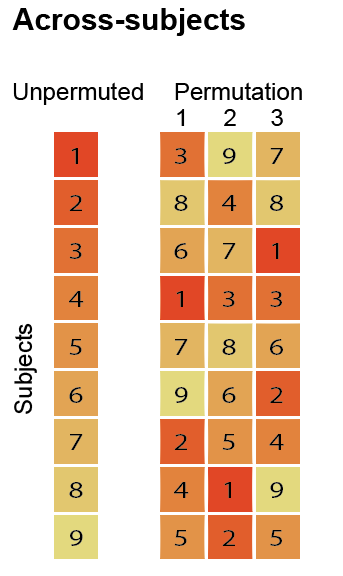

 **Figure 3A**: A 9 x 4 matrix representing permutation testing across subjects. Each row corresponds to a subject, with one observation each. The first column: displays the original index of each subject (perm=0). Next columns: examples of permuted subject indices.



### Family structure <a id="fam-struc"></a>
By default, the ```across_subject``` function assumes exchangeability across all subjects, meaning any pair of subjects can be swapped. However, in reality, familial or meaningful connections between subjects may exist and can therefore violate the assumption that each subject are independent from each other. 

To accommodate these connections, permutation tests with HCP data—or any dataset—involve creating the ```EB.csv``` file (Exchangeability Block). This file organizes data into blocks, each representing a family and makes it possibole to perform collective shuffling of entire families. For a more detailed explanation, refer to ([Winkler et al, 2015](https://www.sciencedirect.com/science/article/pii/S105381191500508X?via%3Dihub)). A tutorial on creating your ```EB.csv``` from the HCP dataset can be found in the glhmm toolbox [here](jdjdj).

When using the ```across_subject``` function to consider family structure, you input a dictionary and we call it ```dict_fam```. This dictionary specifies the directory to load the ```EB.csv``` file and includes optional parameters for running the permutation. In our example, we'll use default options and solely define the file location of the family structure data (EB).

In [10]:
dict_fam = {
    'file_location': 'EB.csv',  # Specify the file location of the family structure data
    # 'file_location': r'C:\Users\...\EB.csv'
}

### Across subjects - Regression <a id="perm-regression"></a>
In regression analysis, we are trying to explain the relationships between predictor variables (```X_data```), such as the Viterbi path, and the response variable or signal (```Y_data```).

**Understanding Regression:**\
The objective is to uncover the factors influencing changes in our behavioral measurements. Specifically, we examine the amount of explained variance, it can be used to analyze whether the ```FO```— representing the distribution of the duration spent in different states— significantly contributes to explaining the observed variability in ```behavioral measurements``` like 'sex' or 'age.'
A significant result indicates that certain patterns in ```FO``` significantly contribute to explaining why the ```behavioral measurements``` varies. A non-significant result, on the other hand, suggests that the observed relationship can be attributed to random chance, implying that the ```FO``` may not play a significant role in accounting for the variability of the ```behavioral measurements```.

**Run the ```across_subjects``` function**:\
To run the ```across_subjects``` function requires providing inputs of ```FO``` (X) and ```data_behavioral``` (Y). Sense we take family structure into account we will also include the variable ```dict_fam``` as an input.  Additionally, you can account for potential confounding variables by regressing them out through permutation testing.
To initiate regression-based permutation testing, set ```method="regression"```.

In this example, we will test how ```FO``` relate to variations in the behavioral variable 'age'.

In [11]:
from permtest import * # This function should just be in the GLHMM package
from palm_functions import *
# Set the parameters for between-subject testing
method = "regression"
Nperm = 10_000 # Number of permutations (default = 1000)

# Perform across-subject testing
result  =across_subjects(FO, data_behavioral[:,1], method=method,Nperm=Nperm,dict_fam=dict_fam)

c:\Users\au323479\Desktop\Permutation_test\GLHMM\Permutation_test_13-11_include_viterbi_path_permutation_matrix\palm_functions.py:1058: RuntimeWarning: overflow encountered in exp
  maxP = np.exp(lmaxP)


Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:00<00:00, 15113.64it/s]


We can now examine the local ```result``` variable.

In [12]:
result

{'pval': array([0.31716828, 0.6660334 , 0.67453255, 0.34666533, 0.44745525,
        0.65613439, 0.0579942 , 0.78512149]),
 'corr_coef': [],
 'test_statistic': [],
 'pval_list': [],
 'test_type': 'across_subjects',
 'method': 'regression'}

What we can see here is that ```result``` is a dictionary that contains the output of a statistical analysis applied using the specified ```method``` and ```test type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a specific state.

* ```corr_coef```: Currently an empty list. It is intended to store correlation coefficients if correlation is involved in the analysis. In this case, the correlation coefficients are not calculated when we have set ```method="regression"```. 

* ```test_statistic```: Currently an empty list. This list could can store the test statistics associated with the permutation test. It provides additional information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```pval_list```: This list is currently empty. It stores the p-values concurrently calculated with correlation coefficients when ```method = "correlation_com"``` using the [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) module.
Note: ```"correlation_com"``` stands for correlation combined and provides both the statistical significance of Pearson's correlation coefficient and a 2-tailed p-value. The output is exported when ```method = "correlation_com"``` and ```test_statistic_option=True```

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```.

* ```method```: Specifies the method employed in the analysis. Here, it is ```'regression'```, indicating that the analysis is conducted using regression-based permutation testing.

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

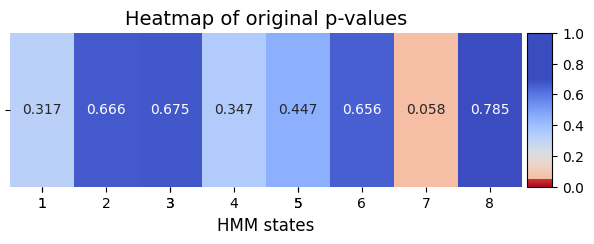

In [13]:
from helperfunctions import plot_heatmap,plot_scatter_with_labels,plot_histograms
# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM states", ylabel="", alpha=0.05)

**Conclusion - Regression**\
Each p-value corresponds to a specific test of the relationship between ```FO``` and the behavioral variable ```'age'```.
The permutation test for explained variance indicated that there is insufficient evidence to reject the null hypothesis for any of the HMM states. This suggests that, based on the statistical analysis, there is no statistically significant relationship between ```FO``` and ```'age'``` are not statistically significant for all states.
Since, none of the states are statistically significant there is no need to explore the data further.

### Across visits - Correlation <a id="perm-correlation"></a>
In correlation analysis, our focus is on unraveling intricate relationships between variables. In this case, we consider ```FO``` as the independent variable (X) and the response variables—```'sex'``` and ```'age'```—as the dependent variables (Y). The goal is to examine the strength and direction of the relationship between the probability distribution of different states in FO ```and``` the observed variability in ```'sex'``` and ```'age'```.

**Permutation test for correlation**:\
Using the permutation test for correlation, we can statistically assess the associations between ```FO``` (X) and the behavioral measurements (Y). A significant result suggests that specific probabilities of states in ```FO``` significantly contribute to the observed variations in ```'sex'``` and ```'age'```. Conversely, a non-significant result indicates that the observed relationship might be attributed to random chance, and ```FO``` may not significantly influence the variability in ```'sex'``` and ```'age'```.

**Run the ```across_visits``` function**:\
To run the ```across_visits``` function we just need to provide inputs in the form of X-data (```FO```) and Y-data (```data_behavioral```). Sense we take family structure into account we will also include the variable ```dict_fam``` as an input. To export the permutation distribution we set ```test_statistic_option=True```. Additionally, we can account for potential confounding variables by regressing them out through permutation testing.
To initiate correlation-based permutation testing, set ```method="correlation_com"```. Note that selecting ```correlation_com``` returns both the correlation coefficients matrix and the p-value matrix, while correlation only returns the correlation coefficients matrix.



In [14]:
# Set the parameters for between-subject testing
method = "correlation_com"
Nperm = 10_000 # Number of permutations (default = 1000)
test_statistic_option=True
# Perform across-subject testing
result  =across_subjects(FO, data_behavioral, method=method,Nperm=Nperm,dict_fam=dict_fam,test_statistic_option=test_statistic_option)

c:\Users\au323479\Desktop\Permutation_test\GLHMM\Permutation_test_13-11_include_viterbi_path_permutation_matrix\palm_functions.py:1058: RuntimeWarning: overflow encountered in exp
  maxP = np.exp(lmaxP)


Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [02:18<00:00, 72.20it/s]


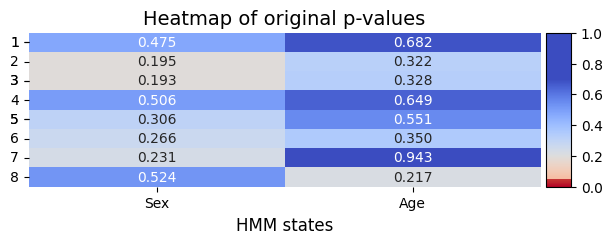

In [17]:
# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM states", ylabel="", alpha=0.05, xticklabels=["Sex", "Age"])

**Plot permutation distribution**\
Presented here are the significant test statistics of our permutation distributionfor the different states.
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

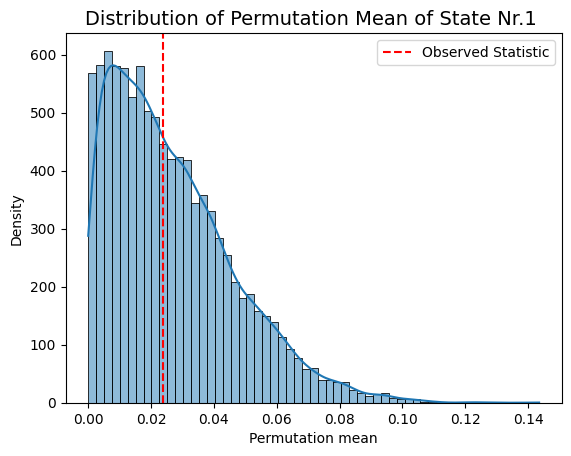

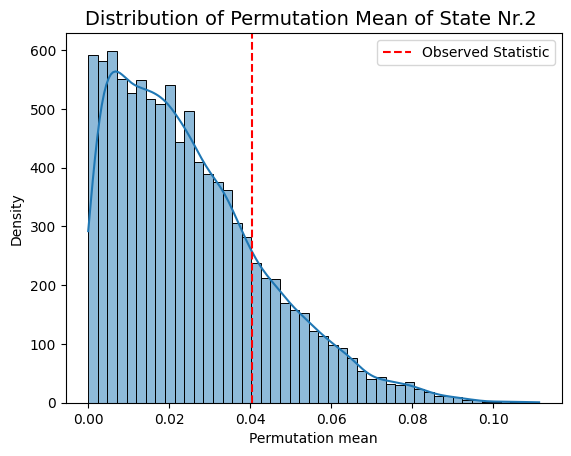

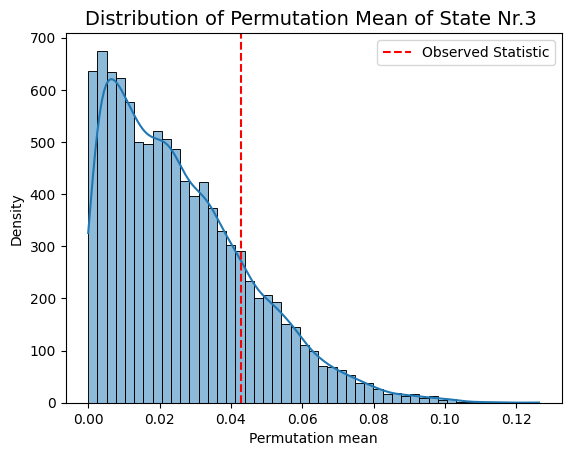

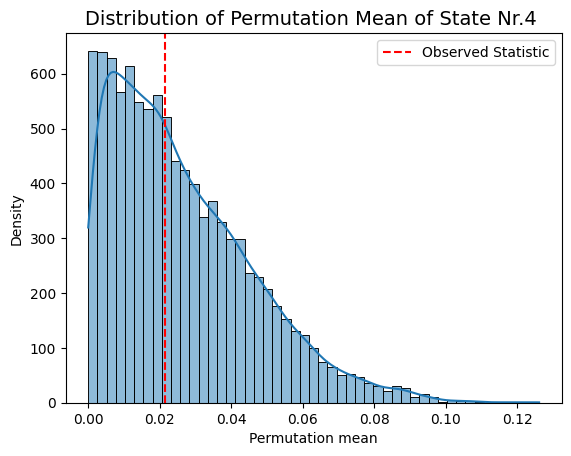

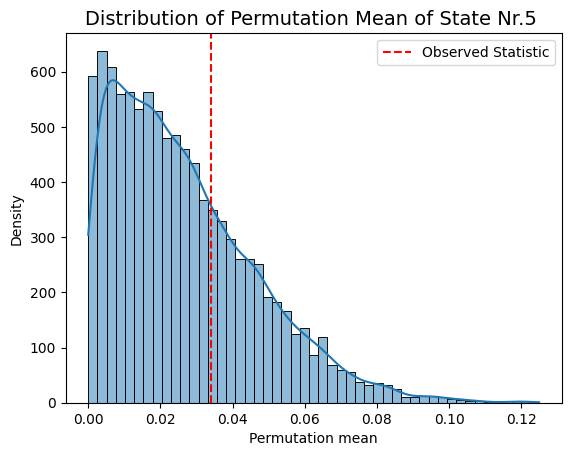

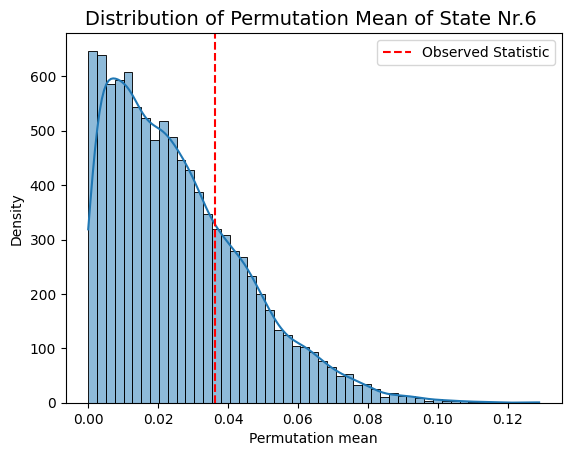

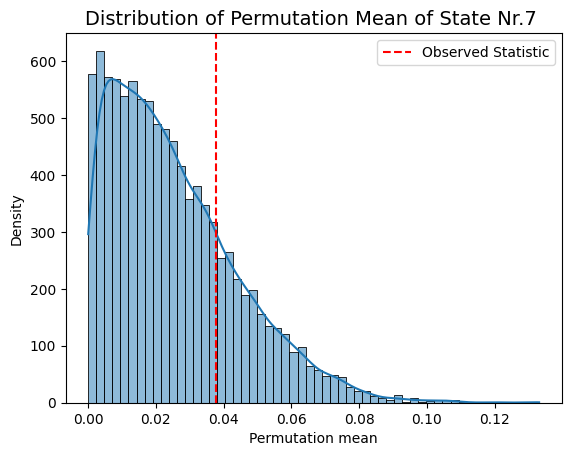

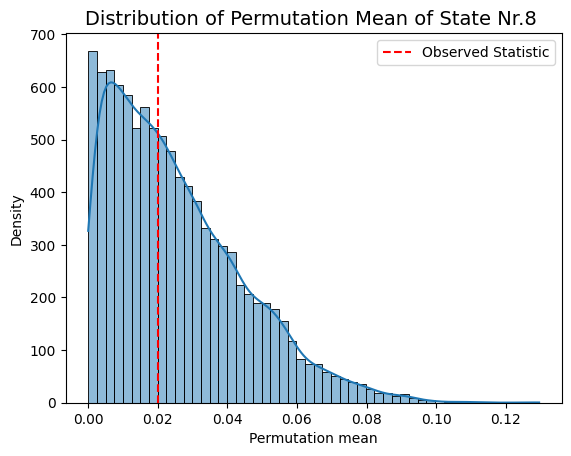

In [18]:
# Plot test statistics for pvals
alpha=0.05
significant_timestamp_position = np.where(result["pval"][:,0] > alpha)
for i in significant_timestamp_position[0]:
    plot_histograms(result["test_statistic"][:,i,0],title_text=f"Distribution of Permutation Mean of State Nr.{i+1} ")

### Conclusion - Correlation
Following permutation testing on correlation across different HMM states derived from FO, the results indicate no statistically significant correlation with the behavioral measurements for 'sex' and 'age'.
With a predetermined alpha value of 0.05, none of the p-values in the matrix fall below this threshold. This suggests that, within the permutation testing framework, there is no evidence to reject the null hypothesis for any specific HMM state. 

What is interesting is that the findings align with the null relationship observed through an alternative prediction approach, which is also part of the GLHMM toolbox. This approach involves predicting age and classifying sex based on all states' FO, switching rates, and lifetimes ([link](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/prediction_tutorial.ipynb)).

Notably, the correlation between model-predicted and true age values is below 0.1, and the accuracy for predicting sex is approximately 60%, just above chance. This implies that if we can't predict age or sex from the comprehensive summary statistics of all states, including FO, switching rates, and lifetimes, we wouldn't expect individual states' FO to exhibit significant correlations with age and sex.

Essentially, despite employing different methodologies, both permutation testing on correlation and the prediction approach concur—there is no strong relationship between HMM summary statistics and age/sex. This consistency is encouraging as it suggests that the permutation test effectively captures the absence of significant correlations in the Human Connectome Project (HCP) dataset.

